In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau

import tensorflow as tf
import random as rn

import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [2]:
input_width = 320
input_height = 120 
n_hid = 1000

lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('./input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup


x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('./input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('./input/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('./input/leapgestrecog/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((input_width, input_height))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
x_data = x_data / 255 * 2 - 1
print(x_data.shape)
#x_data = x_data.reshape(datacount, -1)

y_data = np.array(y_data)
y_data = y_data.reshape(datacount)


(20000, 120, 320)


In [3]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, input_height, input_width, 1))

print(x_data.shape)
print(y_data.shape)
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2, random_state=42)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5, random_state=42)

(20000, 120, 320, 1)
(20000, 10)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(input_height, input_width, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout layer

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))  # Add dropout layer

model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))  # Add dropout layer

model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))  # Add dropout layer

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Add dropout layer

model.add(Dense(10, activation="softmax"))

In [5]:
batch_size=128
epochs=5

In [6]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 320, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 160, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 160, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 160, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 80, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 80, 64)        0

In [7]:
#train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
#history = model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=(x_validate, y_validate))
History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_validate, y_validate))
#History = history
model.save('my_model_w_dropout.h5')

Epoch 1/5
125/125 [==============================] - 308s 2s/step - loss: 1.2880 - accuracy: 0.5433 - val_loss: 0.0596 - val_accuracy: 0.9850
Epoch 2/5
125/125 [==============================] - 299s 2s/step - loss: 0.0653 - accuracy: 0.9791 - val_loss: 0.0044 - val_accuracy: 0.9990
Epoch 3/5
125/125 [==============================] - 289s 2s/step - loss: 0.0254 - accuracy: 0.9929 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 4/5
125/125 [==============================] - 296s 2s/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 8.2581e-04 - val_accuracy: 1.0000
Epoch 5/5
125/125 [==============================] - 300s 2s/step - loss: 0.0090 - accuracy: 0.9973 - val_loss: 6.1961e-04 - val_accuracy: 0.9995


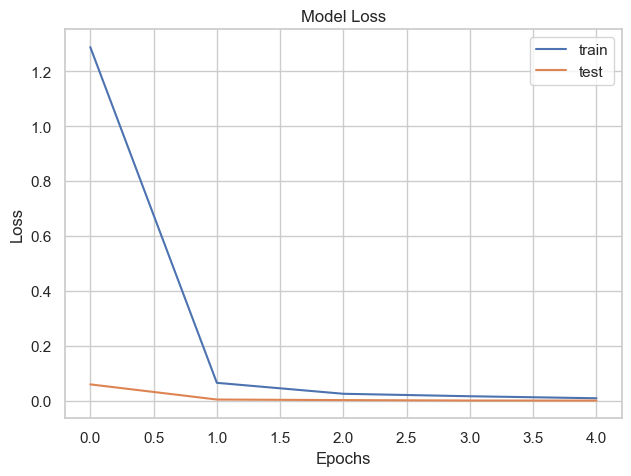

In [8]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

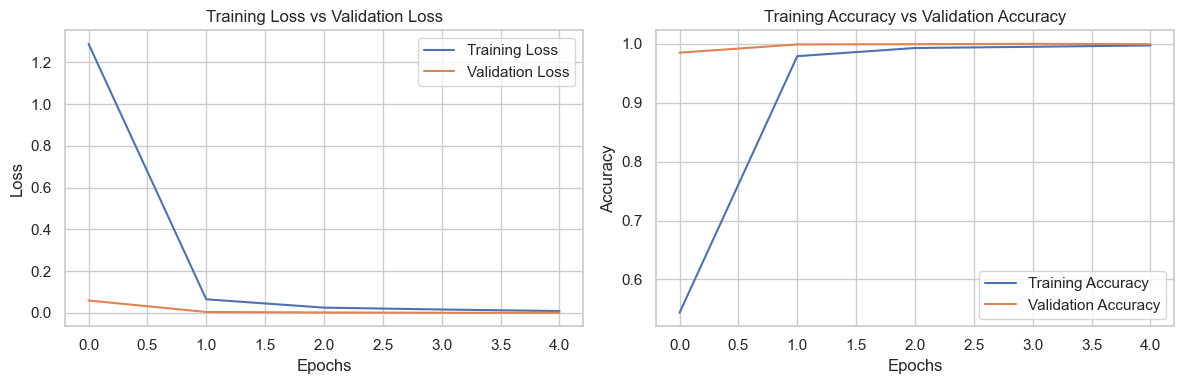

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(History.history['loss'], label='Training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(History.history['accuracy'], label='Training Accuracy')
plt.plot(History.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 115ms/step


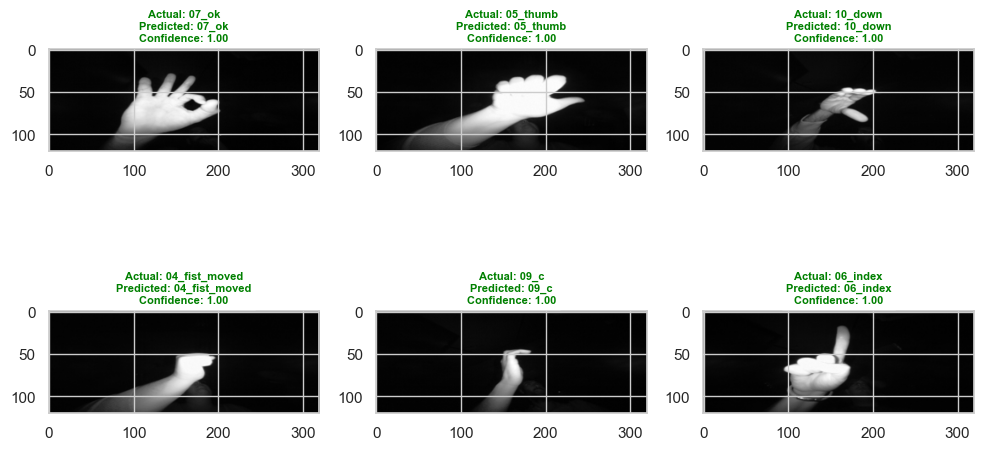

In [10]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Assuming you have a function to reverse lookup the class indices
def reverse_lookup(index):
    return reverselookup[index]

# Select random samples from the test set
num_samples_to_visualize = 6
random_indices = random.sample(range(len(x_test)), num_samples_to_visualize)
x_random_samples = x_test[random_indices]
y_random_labels = y_test[random_indices]  # Assuming y_test contains the true labels

# Make predictions on the randomly selected test samples
predictions_random = model.predict(x_random_samples)

# Visualize predictions for the randomly selected test samples in 2 rows
num_rows = 2
num_cols = num_samples_to_visualize // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        # Plot the original image
        axes[i, j].imshow(x_random_samples[index].reshape(input_height, input_width), cmap='gray')

        # Print the confidence score in bold black color
        predicted_class = np.argmax(predictions_random[index])
        actual_class = np.argmax(y_random_labels[index])
        confidence = predictions_random[index][predicted_class]

        title_color = 'green' if predicted_class == actual_class else 'red'
        axes[i, j].set_title(f'Actual: {reverse_lookup(actual_class)}\nPredicted: {reverse_lookup(predicted_class)}\nConfidence: {confidence:.2f}', color=title_color, backgroundcolor='white', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

63/63 [==============================] - 7s 111ms/step


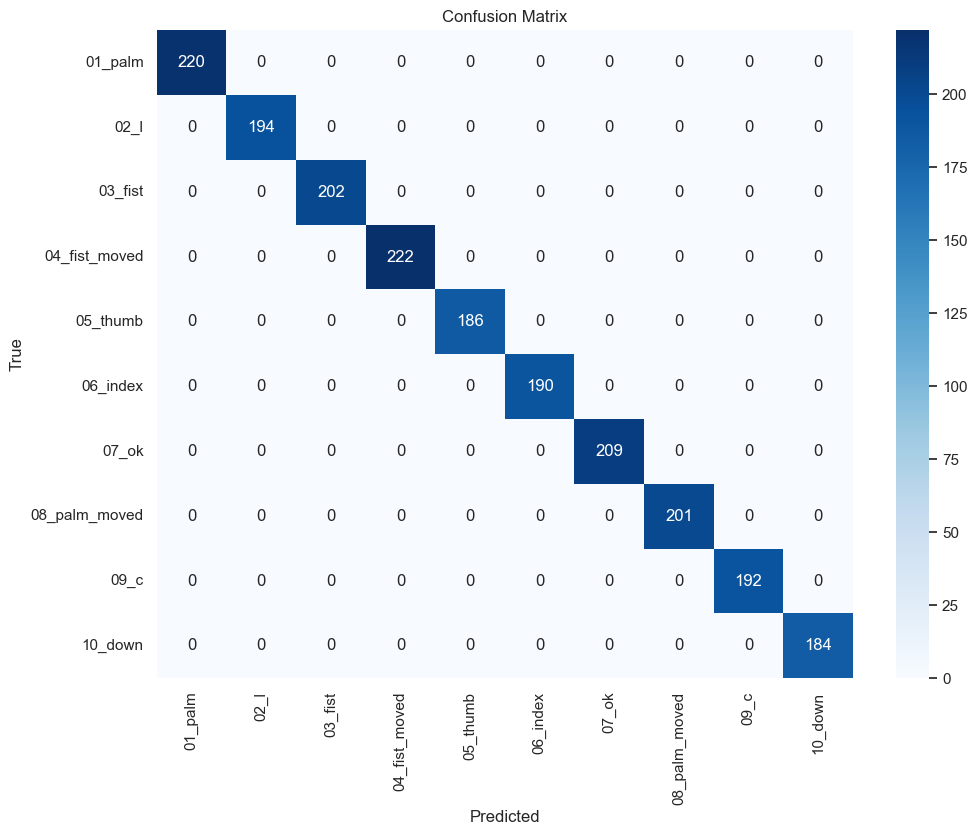

In [11]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=reverselookup.values(),
            yticklabels=reverselookup.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

63/63 [==============================] - 7s 109ms/step


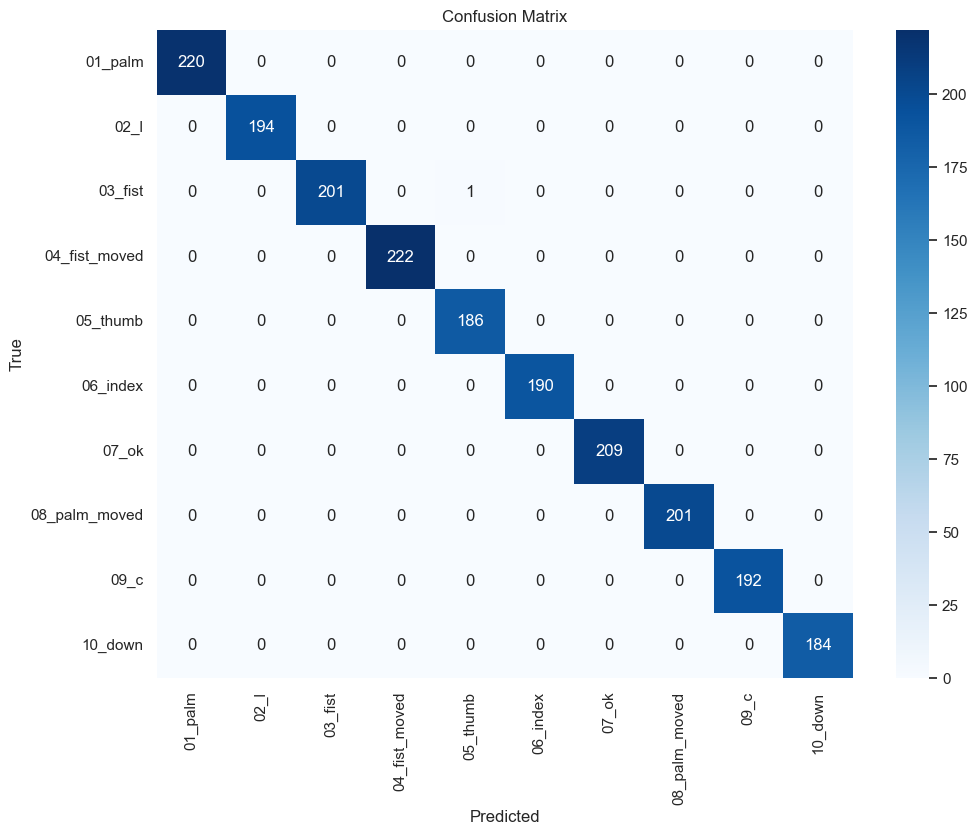

In [14]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=reverselookup.values(),
            yticklabels=reverselookup.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()